In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from ast import literal_eval
from collections import Counter
%matplotlib inline

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

from gensim.parsing.preprocessing import STOPWORDS


### Read in Data, Preprocess

In [2]:
medium = pd.read_csv('medium_dataset.csv')

# The allTags column needs to be converted to type list. By default pandas will read the lists in as strings.
def convert_tags(tags):
    try:
        tags = literal_eval(tags)
        return tags
    except:
        return tags

medium['allTags'] = medium['allTags'].apply(convert_tags)

processed_text = pd.read_csv('processed_text.csv', engine = 'python')
processed_text.drop(columns = 'Unnamed: 0')
medium = medium.merge(processed_text, on = 'title')

medium = medium[medium['totalClapCount'] >= 25]
medium.reset_index(drop = True, inplace = True)

medium = medium[['title', 'allTags', 'firstPublishedDatetime', 'url', 'readingTime', 'processedText']]

In [3]:
processed_text = 0

In [4]:
# When merging it seems a few messed up rows were generated with null values. remove these.

medium.drop(index = medium[medium['processedText'].isnull() == True].index, inplace = True)

In [5]:
stop_list = STOPWORDS.union(set(['data', 'ai', 'learning', 'time', 'machine', 'like', 'use', 'new', 'intelligence', 'need', "it's", 'way',
                                 'artificial', 'based', 'want', 'know', 'learn', "don't", 'things', 'lot', "let's", 'model', 'input',
                                 'output', 'train', 'training', 'trained', 'it', 'we', 'don', 'you', 'ce', 'hasn', 'sa', 'do', 'som',
                                 'can']))

In [6]:
vectorizer = TfidfVectorizer(stop_words = stop_list, ngram_range = (1,1))
doc_word = vectorizer.fit_transform(medium['processedText'])
doc_word.shape

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  sorted(inconsistent))


(24328, 122166)

### NMF with TFIDF

In [7]:
nmf = NMF(8)
doc_topic = nmf.fit_transform(doc_word)

In [8]:
def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
    count = 0
    for ix, topic in enumerate(model.components_):
        if count == no_top_topics:
            break
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", (ix + 1))
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        count += 1

In [245]:
display_topics(nmf, vectorizer.get_feature_names(), 10, 8, topic_names = topic_names)


Topic: ' Tech '
human, robot, technolog, peopl, machin, world, think, futur, brain, job

Topic: ' Modeling '
valu, predict, variabl, featur, regress, function, algorithm, linear, set, test

Topic: ' Chatbots '
chatbot, bot, custom, user, convers, messag, servic, chat, busi, messeng

Topic: ' Deep Learning '
network, imag, layer, neural, deep, convolut, neuron, cnn, weight, function

Topic: ' Coding '
file, tensorflow, python, imag, code, instal, api, run, notebook, googl

Topic: ' Business '
blockchain, market, technolog, compani, busi, custom, product, platform, servic, token

Topic: ' Careers '
scienc, scientist, cours, work, skill, team, job, peopl, project, engin

Topic: ' NLP '
word, vector, text, sentenc, embed, languag, document, sentiment, nlp, corpu


### Name Topics and Save Results

In [10]:
topic_names = ['Tech', 'Modeling', 'Chatbots', 'Deep Learning', 'Coding', 'Business', 'Careers', 'NLP']

In [11]:
topic_words = ['Human, Robot, Technology, People, Machine',
               'Value, Predict, Variable, Feature, Regression',
               'Chatbot, Bot, Customer, User, Conversation',
               'Network, Image, Layer, Neural, Deep',
               'File, Python, Image, Code, Install',
               'Blockchain, Market, Company, Business, Product',
               'Scientist, Course, Work, Skill, Team',
               'Word, Vector, Text, Sentence, Embed']

In [124]:
column_names = ['title', 'url', 'allTags', 'readingTime', 'Tech', 'Modeling', 'Chatbots', 'Deep Learning', 'Coding', 'Business', 'Careers', 'NLP']
doc_topic_df = pd.DataFrame(data = doc_topic)
doc_topic_df.reset_index(drop = True, inplace = True)
medium.reset_index(drop = True, inplace = True)
doc_topic_df = pd.concat([medium[['title', 'url', 'allTags', 'readingTime']], doc_topic_df], axis = 1)
doc_topic_df.columns = column_names
doc_topic_df.to_csv('doc_topics/tfidf_nmf_8topics.csv', index = False)
doc_topic_df.head(10)

,title,url,allTags,readingTime,Tech,Modeling,Chatbots,Deep Learning,Coding,Business,Careers,NLP
0,"Private Business, Government and Blockchain",https://medium.com/s/story/private-business-go...,"[Blockchain, Samsung, It]",0.958491,0.003274,0.000000,0.000000,0.000000,0.000000,0.076575,0.000000,0.000000
1,Can a robot love us better than another human ...,https://medium.com/s/story/can-a-robot-love-us...,"[Robotics, Meditation, Therapy, Artificial Int...",0.652830,0.052594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"2017 Big Data, AI and IOT Use Cases",https://medium.com/s/story/2017-big-data-ai-an...,"[Artificial Intelligence, Data Science, Big Da...",7.055031,0.020592,0.016506,0.000000,0.011496,0.004362,0.044861,0.016316,0.000000
3,The Meta Model and Meta Meta-Model of Deep Lea...,https://medium.com/s/story/the-meta-model-and-...,"[Machine Learning, Deep Learning, Artificial I...",5.684906,0.008734,0.001640,0.000000,0.045441,0.000836,0.000000,0.009885,0.006307
4,Don’t trust “Do you trust this computer”,https://medium.com/s/story/dont-trust-do-you-t...,"[Artificial Intelligence, Ethics, Elon Musk, D...",2.739623,0.026799,0.005586,0.003179,0.000000,0.000545,0.005267,0.017274,0.004096
5,AI based UI Development (AI-UI),https://medium.com/s/story/ai-based-ui-develop...,"[Machine Learning, Artificial Intelligence, De...",5.705660,0.023335,0.000000,0.006009,0.051248,0.035063,0.004568,0.010492,0.057667
6,Can Technology Replace Record Companies?,https://medium.com/s/story/can-technology-repl...,"[Music, Business, Data Science, Business Strat...",3.205975,0.008898,0.007189,0.002466,0.000432,0.000000,0.051221,0.029810,0.000000
7,Five tech trends that shaped 2017,https://medium.com/s/story/five-tech-trends-th...,"[Artificial Intelligence, Trends, Venture Capi...",4.416038,0.022113,0.012507,0.002418,0.000168,0.000000,0.070791,0.000000,0.000000
8,Vectorized implementation of back-propagation,https://medium.com/s/story/vectorized-implemen...,"[Machine Learning, Neural Networks, Backpropag...",5.348428,0.000000,0.047683,0.000000,0.025370,0.002062,0.000000,0.000000,0.035136
9,Building Smarter Businesses With Cognitive Ser...,https://medium.com/s/story/building-smarter-bu...,"[Artificial Intelligence, Machine Learning, Co...",6.069811,0.026020,0.000000,0.025512,0.007639,0.014731,0.043691,0.000000,0.010116


### Build pyldavis style plot in Bokeh

In [14]:
topic_strength = np.sum(doc_topic, axis = 0)
print(topic_strength)

[311.88142016 307.90581222 182.7436377  230.8928612  314.82157683
 389.82169153 327.34683269 188.68972613]


In [220]:
adjustment = 10/np.max(doc_topic)

In [221]:
adjustment

40.25186407228774

In [15]:
# Save topic components and run SVD(2) on them. This will allow the topics to be plotted in 2D.
topics = nmf.components_

In [16]:
lsa = TruncatedSVD(2)
topics2D = lsa.fit_transform(topics)
sum(lsa.explained_variance_ratio_)

0.29612377460968636

In [17]:
topics2D

array([[ 3.95880149, -1.87770049],
       [ 2.26994545,  1.56844503],
       [ 1.28125477, -0.75777582],
       [ 2.08622884,  3.3229708 ],
       [ 1.51903561,  0.68677364],
       [ 2.44177456, -0.9660976 ],
       [ 2.3932953 , -0.56435253],
       [ 1.02189958,  0.56561959]])

In [18]:
pc1 = []
pc2 = []

for topic in topics2D:
    pc1.append(topic[0])
    pc2.append(topic[1])

pc1 = np.array(pc1)
pc2 = np.array(pc2)

pc1 = pc1 - np.mean(pc1)
pc2 = pc2 - np.mean(pc2)

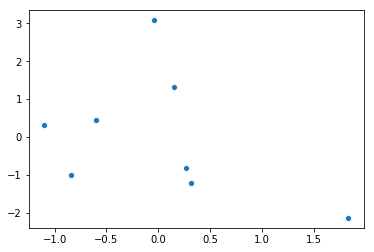

In [19]:
# This crudely shows which topics are most similar
# Find a prettier way to plot this
sns.scatterplot(pc1, pc2)

In [22]:
from bokeh.embed import components #generates javascript to be embedded on web page
from bokeh.plotting import show, figure
from bokeh.models import ColumnDataSource, LinearColorMapper, BasicTicker, PrintfTickFormatter, HoverTool, CategoricalColorMapper, LabelSet
from bokeh.palettes import Spectral
from bokeh.transform import transform

from bokeh.io import output_notebook #render in notebook
output_notebook()

Loading BokehJS ...

In [122]:
scale = 5
topic_scaled = topic_strength / scale


df = pd.DataFrame({'x': pc1, 'y': pc2, 'count': topic_strength, 'count_scaled': topic_scaled,
                   'topics': topic_names, 'words': topic_words})

# df = pd.DataFrame(data = d)
source = ColumnDataSource(df)
p = figure(plot_width=500, plot_height=500, x_range = (-1.5, 2.5), y_range = (-2.7, 3.7))

color_mapper = CategoricalColorMapper(factors = df['topics'], 
                                     palette= Spectral[8])

p.circle('x', 'y', source = df, legend = 'topics', size = 'count_scaled', alpha = 0.7,
                   color={ #map color to target classes
                       'field': 'topics',
                       'transform': color_mapper
                   })

p.add_tools(HoverTool(tooltips = [('Topic', '@topics'), ('Top Words', '@words')]))

show(p)

In [246]:
script, div = components(p)

with open('bokeh/script.js', 'w') as file:
    file.write(script)
    file.close()

with open('bokeh/div.html', 'w') as file:
    file.write(div)
    file.close()

### Build Recommender Script

In [111]:
tech = 3
modeling = 4
chatbots = 1
deep = 5
coding = 3
business = 4
careers = 2
nlp = 6

top_vec = np.array([tech, modeling, chatbots, deep, coding, business, careers, nlp])

In [56]:
topic_array = np.array(doc_topic_df[topic_names])
norms = np.linalg.norm(topic_array, axis = 1)

In [131]:
top_vec + np.random.rand(8,)/5

array([3.1228744 , 4.01058191, 1.10618451, 5.00128214, 3.0778294 ,
       4.15016961, 2.19988222, 6.03756152])

In [230]:
def compute_dists(top_vec, topic_array):
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)

    return co_dists

def produce_rec(top_vec, topic_array = topic_array, metadata = doc_topic_df):
    # Add a bit of randomness to top_vec
    top_vec = top_vec + np.random.rand(8,)/(np.sum(top_vec)*0.005)
    co_dists = compute_dists(top_vec, topic_array)
    return metadata.loc[np.argmax(co_dists)]

In [237]:
rec = produce_rec(top_vec, topic_array, doc_topic_df)

rec

title            Building the Next Generation of Personalized T...
url              https://engineering.pandora.com/building-the-n...
allTags          [Machine Learning, Streaming Music, Pandora, D...
readingTime                                                7.63585
Tech                                                    0.00735476
Modeling                                                 0.0125969
Chatbots                                                0.00270124
Deep Learning                                           0.00838692
Coding                                                  0.00386756
Business                                                0.00600131
Careers                                                 0.00747548
NLP                                                      0.0190519
Name: 18005, dtype: object

In [242]:
rec['url']

'https://engineering.pandora.com/building-the-next-generation-of-personalized-themed-playlists-43f567b964f9'

### Build bokeh radar plot to display article topic distribution

In [228]:
def build_radar_plot(metadata, topic_names = topic_names):
    num_vars = 8

    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def unit_poly_verts(theta):
        """Return vertices of polygon for subplot axes.
        This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
        """
        x0, y0, r = [0.5] * 3
        verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
        return verts

    def radar_patch(r, theta):
        yt = (r + 0.01) * np.sin(theta) + 0.5
        xt = (r + 0.01) * np.cos(theta) + 0.5
        return xt, yt

    verts = unit_poly_verts(theta)
    x = [v[0] for v in verts] 
    y = [v[1] for v in verts] 

    p = figure(title="Article Topic Distribution", x_range = (-0.05, 1.2), y_range = (-0.15, 1.15),
              plot_width = 500, plot_height = 500)
    
    text = topic_names + ['']
    source = ColumnDataSource({'x':x+ [0.5],'y':y+ [1],'text':text})

    p.line(x="x", y="y", source=source)

    labels = LabelSet(x="x",y="y",text="text",source=source)

    p.add_layout(labels)

    # example factor:
    f1 = metadata[topic_names].values
    f1 = f1 * (0.49 / np.max(f1))

    #xt = np.array(x)
    color = Spectral[8][np.argmax(f1)]
    xt, yt = radar_patch(f1, theta)
    p.patch(x=xt, y=yt, fill_alpha=0.15, fill_color=color)
    show(p)

In [229]:
build_radar_plot(rec)